Self Driving Car Engineer Nanodegree
Project: Advanced Lane Finding



In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        #polynomial coefficients averaged over the last n iterations
        #pixel fit
        self.best_fit = None  
        #fit for pixels converted to 'real world' measurement
        self.best_fit_m = None
        
        #polynomial coefficients for n last iterations
        #pixel_fit
        self.recent_fit = []
        #fit for pixels converted to 'real world' measurement
        self.recent_fit_m = []
        #list of center offsets
        self.line_base_pos_recent = []
        
        #polynomial coefficients for the most recent fit
        #pixel_fit
        self.current_fit = [np.array([False])]  
        #fit for pixels converted to 'real world' measurement
        self.current_fit_m = [np.array([False])]  
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        
        #radius of curvature of the line in some units 20 most recent
        self.radius_of_curvature_recent = [] 
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        #x values for detected line pixels
        self.allx = None  
        
        #y values for detected line pixels
        self.ally = None
    
    def add_xfitted(self,current_fit):
        self.current_fit=current_fit
        self.recent_fit.append(current_fit.tolist())
        n_indices = min(len(self.recent_fit),20)
        self.recent_fit = self.recent_fit[-n_indices:]
        self.best_fit = np.mean(np.array(self.recent_fit),axis = 0)
        
    def add_xfitted_m(self,current_fit):
        self.current_fit_m=current_fit
        self.recent_fit_m.append(current_fit.tolist())
        n_indices = min(len(self.recent_fit_m),20)
        self.recent_fit_m = self.recent_fit_m[-n_indices:]
        self.best_fit_m = np.mean(np.array(self.recent_fit_m),axis = 0)
        #calculate lane characteristics
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        y_eval = 720
        self.radius_of_curvature = ((1 + (2*self.best_fit_m[0]*y_eval*ym_per_pix + self.best_fit_m[1])**2)**1.5) / np.absolute(2*self.best_fit_m[0])
        
    def add_center(self,center_offset):
        self.line_base_pos_recent.append(center_offset)
        n_indices = min(len(self.recent_fit_m),20)
        self.line_base_pos_recent = self.line_base_pos_recent[-n_indices:]
        self.line_base_pos = np.mean(self.line_base_pos_recent)

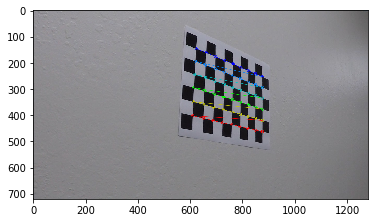

In [2]:
#Finding Corners

#number of corners in the images
nx = 9
ny = 6

#Arrays to store object points and image points for all the images
objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found
    if ret == True:
        # add object points, image points
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
plt.imshow(img)

In [3]:
#Calibrate the camera
#dist = distortion coefficients
#mtx = camera matrix
#rvecs = rotation vector
#tvecs = translation vector
#retrieve teh grayscale image shape with gray.shape[::-1]-> (width, height in pixel values)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [4]:
#Undistort the images
def undistort(gray_img,mtx,dist):
    undst = cv2.undistort(gray_img, mtx, dist, None, mtx)
    return undst

In [5]:
#function to return a binary image based on the gradient in the x or y ditrection
def abs_sobel_thresh(gray_img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Take the absolute value of the output from cv2.Sobel()
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply lower and upper thresholds
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    # Create binary_output
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

In [6]:
#function to return a binary image based on the magnitude of the gradient
def mag_thresh(gray_img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    #plt.imshow(binary_output, cmap='gray')
    # Return the binary image
    return binary_output

In [7]:
#function to return a binary image based on the direction of the gradient
def dir_threshold(gray_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    #plt.imshow(binary_output, cmap='gray')
    # Return the binary image
    return binary_output

In [8]:
#function to return a binary image based on the value of a layer in an image
def gen_threshold(layer_img, min_threshold = 0, max_threshold = 255):
    binary_out = np.zeros_like(layer_img)
    binary_out[(layer_img >= min_threshold) & (layer_img <= max_threshold)] = 1
    return binary_out

In [9]:
#warp the image so the lines are straight - assume the image is undistorted
def unwarp(gray_img):
    img_size = (gray_img.shape[1], gray_img.shape[0])
    center = gray_img.shape[1]//2 #find the center
    x_btm = 380 # add and subtract to the center to define the bottom of the source img
    x_top = 77 #adjust this number until the lines appear vertical in straight_lines1 and straight_lines1
    y_btm = 720 #max image size
    y_top = 480 #the top of where the lane marker will end
    src = np.float32([[center - x_btm, y_btm],[center + x_btm, y_btm],[center - x_top, y_top],[center + x_top, y_top]])
    #squish the image in the destination so we can accommodate the bend when the curve get sharp (+/- 100)
    dst = np.float32([[center - x_btm+100,y_btm],[center + x_btm-100,y_btm],[center - x_btm+100,0],[center + x_btm-100,0]])
    #Calculate the perspective transforms
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    #Warp the image
    warped = cv2.warpPerspective(gray_img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped.astype(np.uint8), M, Minv

In [10]:
#fit the polynomial in the image (this version is used for the rough pipeline)
def poly_lanes_search(binary_warped):
    #need to find a better way of passing the Line() class
    #global leftLine, rightLine
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
       
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    #stacks the 9 results into a vector
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    #leftLine.allx = leftx
    
    lefty = nonzeroy[left_lane_inds] 
    #leftLine.ally = lefty
    
    rightx = nonzerox[right_lane_inds]
    #rightLine.allx = rightx
    
    righty = nonzeroy[right_lane_inds]
    #rightLine.allx = righty

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    leftLine.add_xfitted(left_fit)
    right_fit = np.polyfit(righty, rightx, 2)
    rightLine.add_xfitted(right_fit)
    
    ploty = np.linspace(0, combined_warped.shape[0]-1, combined_warped.shape[0])
    #compute the fitted line
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = 720

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_lane_inds, right_lane_inds, left_curverad, right_curverad, left_fitx, right_fitx

In [11]:
#Create a seperate function for doing the sliding windows search
def sliding_windows_search(binary_warped):
    #Define the margin for searching
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
       
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    #stacks the 9 lists into a single vector
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return left_lane_inds, right_lane_inds
   

In [12]:
def poly_lanes(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Define the margin for searching
    margin = 100
        
    #Get all the indices within the margin bounds
    #if we haven't found a good amount of images to average over:
    num_pics_avg = 20
    if len(leftLine.recent_fit) < num_pics_avg or len(rightLine.recent_fit) < num_pics_avg:
        left_lane_inds, right_lane_inds = sliding_windows_search(binary_warped)
    #else, search within the latest line
    else:
        #use the averaged fit coefficients to do the searching
        left_fit_avg = leftLine.best_fit.tolist()
        right_fit_avg = rightLine.best_fit.tolist()
        
        left_lane_inds = ((nonzerox > (left_fit_avg[0]*(nonzeroy**2) + left_fit_avg[1]*nonzeroy + 
        left_fit_avg[2] - margin)) & (nonzerox < (left_fit_avg[0]*(nonzeroy**2) + 
        left_fit_avg[1]*nonzeroy + left_fit_avg[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit_avg[0]*(nonzeroy**2) + right_fit_avg[1]*nonzeroy + 
        right_fit_avg[2] - margin)) & (nonzerox < (right_fit_avg[0]*(nonzeroy**2) + 
        right_fit_avg[1]*nonzeroy + right_fit_avg[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    
    lefty = nonzeroy[left_lane_inds] 
    
    rightx = nonzerox[right_lane_inds]
    
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each set of found points
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #Define the
    ploty = np.linspace(0, combined_warped.shape[0]-1, combined_warped.shape[0])
    
    y_eval = 720
    #compute the fitted line
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_posx = left_fitx[-1]
    
    #calculate lane characteristics
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    

    #Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    #Calculate the difference between the two lines
    lane_diff_avg = np.mean(np.array(right_fitx)-np.array(left_fitx))
    
    #if lanes are valid, add the values
    if ((lane_diff_avg > 600) & ((left_curverad + right_curverad)/2.0 > 200)):
        leftLine.add_xfitted(left_fit)
        rightLine.add_xfitted(right_fit)
        leftLine.add_xfitted_m(left_fit_cr)
        rightLine.add_xfitted_m(right_fit_cr)
        leftLine.add_center((left_posx+lane_diff_avg/2.0-640.0)*xm_per_pix)

27519.8246467 31617.3879946


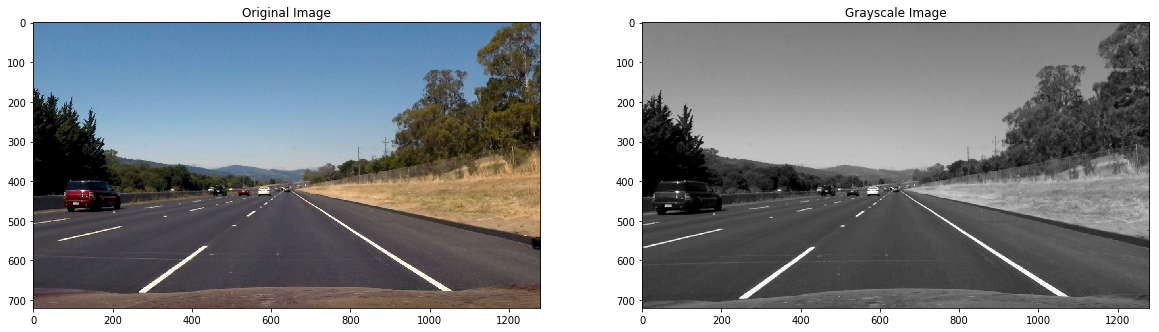

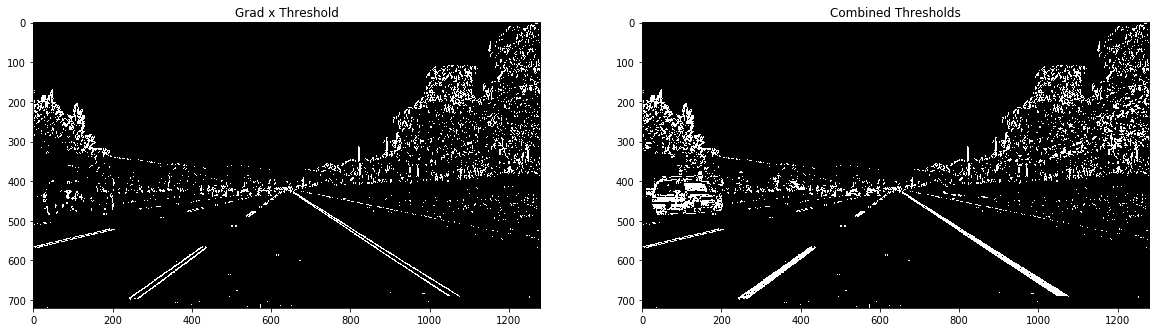

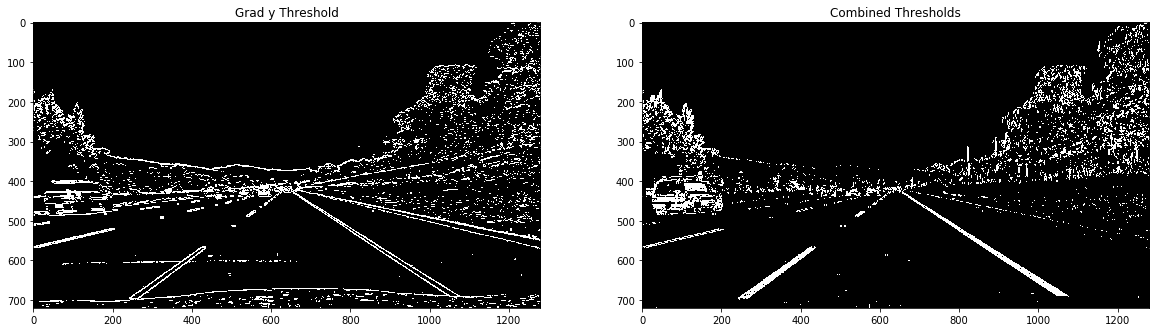

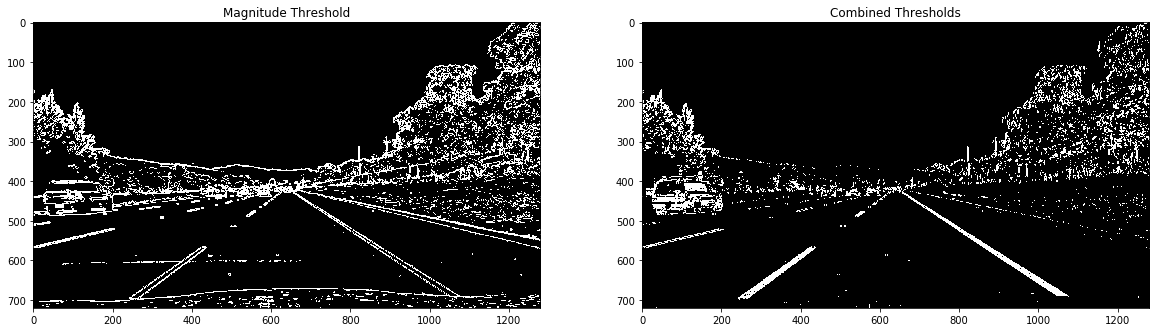

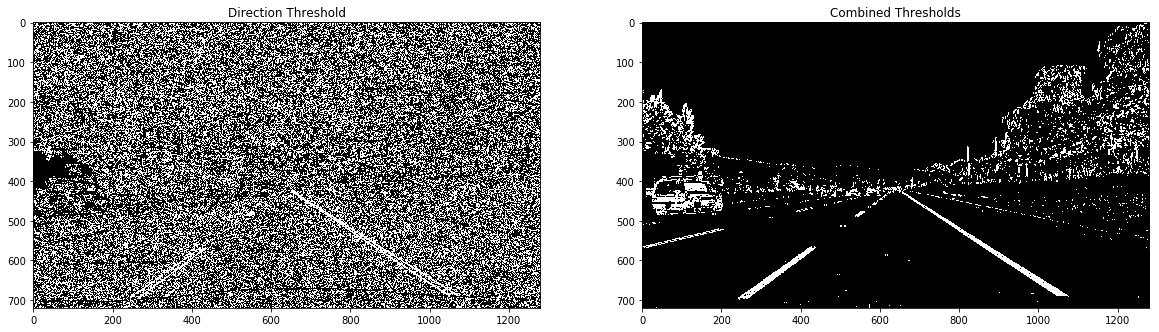

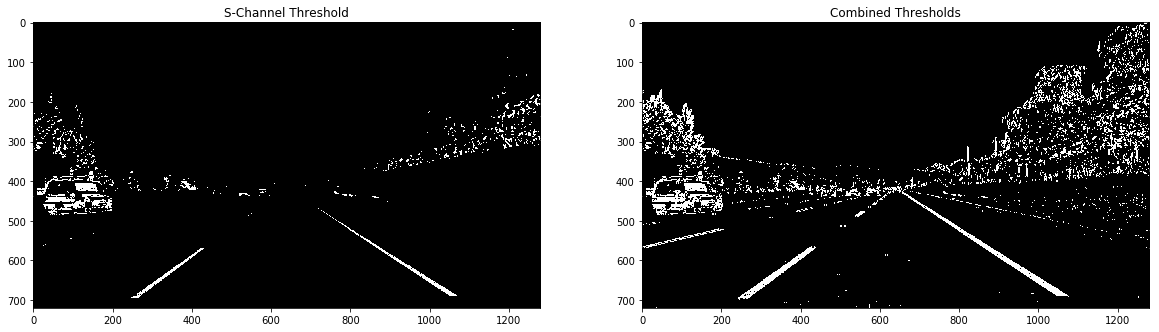

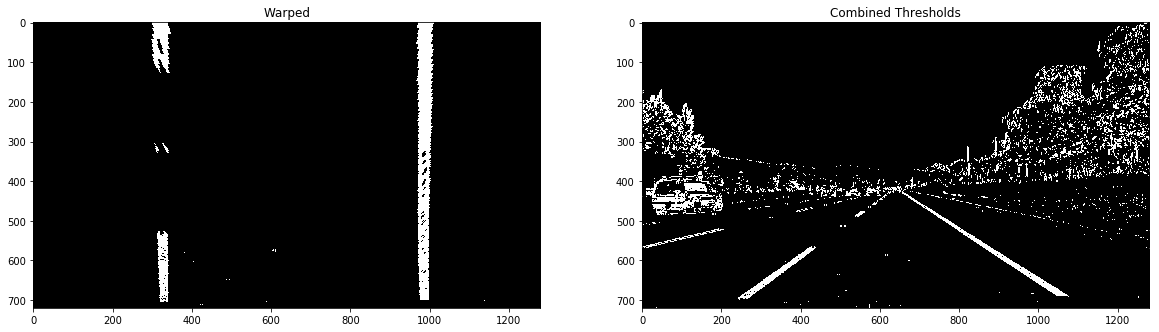

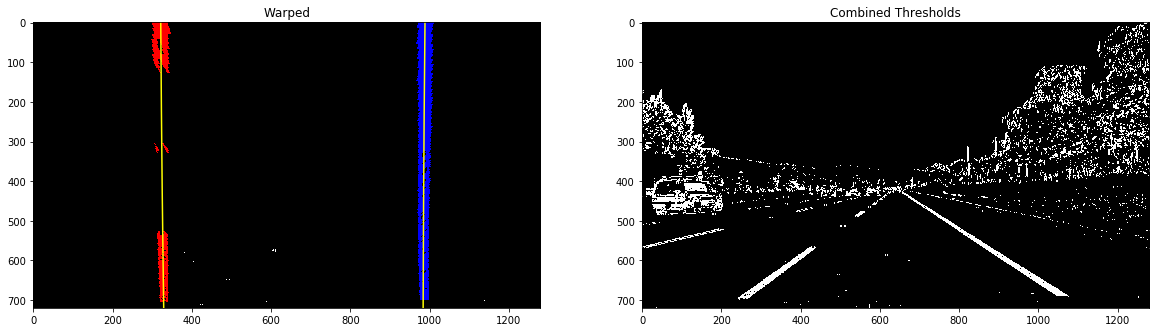

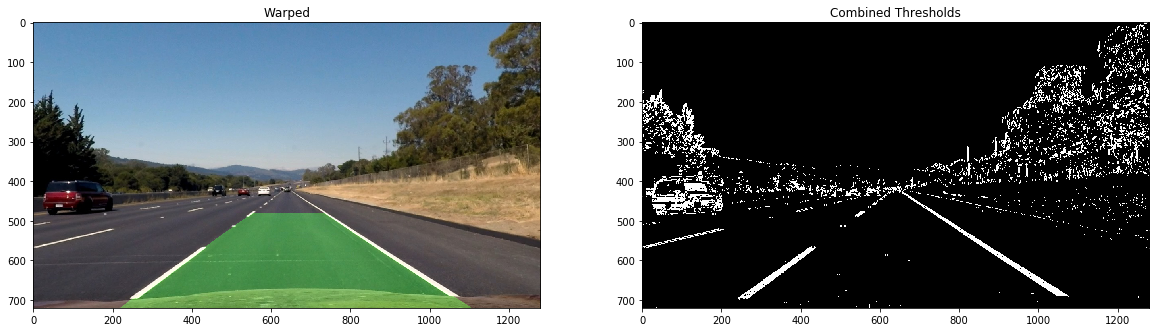

In [13]:
#Rough pipeline to check output
#create Class instances to hold line characteristics.  Use python scoping rules. Don't assign a variable directly to avoid keeping these local
leftLine = Line()
rightLine = Line()
ksize = 3

#load the image
fname = 'test_images/straight_lines2.jpg'
img = mpimg.imread(fname)

#undistort the image
undist = np.copy(img)
undist = undistort(undist,mtx,dist)

#apply grayscale
gray = cv2.cvtColor(np.copy(undist), cv2.COLOR_RGB2GRAY)

#channel to hls colorspace
hls =  cv2.cvtColor(np.copy(undist), cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

#create the sobel threshold binary pics
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 200))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 250))

#make a binary pic from the sobel magnitude
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 200))

#make a binary pic from the sobel direction
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Threshold color channel
s_binary = gen_threshold(s_channel,170,255)

#Make a combined image. First initialize to zero
combined = np.zeros_like(dir_binary)
#Then combine the thresholds that were created
combined[(gradx == 1) | (s_binary==1)] = 1
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary==1)] = 1

#Unwarp the image and compute the transformation matrices
combined_warped, M, Minv = unwarp(combined)

#Detect lane lines (old version)
left_lane_inds, right_lane_inds, left_curverad, right_curverad, left_fitx, right_fitx = poly_lanes_search(combined_warped)

#y values to do the plotting for f(y)
ploty = np.linspace(0, combined_warped.shape[0]-1, combined_warped.shape[0])

#create the output image
out_img = np.dstack((combined_warped*255, combined_warped*255, combined_warped*255))
#find all the non-zero elmemnts for plotting
nonzero = combined_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Create an image to draw the lines on
warp_zero = np.zeros_like(combined_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)


#plot the images
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(img)
ax2.imshow(gray,cmap = 'gray')
ax1.set_title('Original Image')
ax2.set_title('Grayscale Image')

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(gradx, cmap = 'gray')
ax2.imshow(combined,cmap = 'gray')
ax1.set_title('Grad x Threshold')
ax2.set_title('Combined Thresholds')

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(grady, cmap = 'gray')
ax2.imshow(combined,cmap = 'gray')
ax1.set_title('Grad y Threshold')
ax2.set_title('Combined Thresholds')

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(mag_binary, cmap = 'gray')
ax2.imshow(combined,cmap = 'gray')
ax1.set_title('Magnitude Threshold')
ax2.set_title('Combined Thresholds')

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(dir_binary,cmap = 'gray')
ax2.imshow(combined,cmap = 'gray')
ax1.set_title('Direction Threshold')
ax2.set_title('Combined Thresholds')

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(s_binary,cmap = 'gray')
ax2.imshow(combined,cmap = 'gray')
ax1.set_title('S-Channel Threshold')
ax2.set_title('Combined Thresholds')

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(combined_warped,cmap = 'gray')
ax2.imshow(combined,cmap = 'gray')
ax1.set_title('Warped')
ax2.set_title('Combined Thresholds')

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(out_img)
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color ='yellow')
ax2.imshow(combined,cmap = 'gray')
ax1.set_title('Warped')
ax2.set_title('Combined Thresholds')

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(result)
ax2.imshow(combined,cmap = 'gray')
ax1.set_title('Warped')
ax2.set_title('Combined Thresholds')

#Check the radii of curvature
print(left_curverad, right_curverad)

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    ksize = 3
    
    #undistort the image
    undist = np.copy(img)
    undist = undistort(undist,mtx,dist)
    
    #convert to grayscale
    gray = cv2.cvtColor(np.copy(undist), cv2.COLOR_RGB2GRAY)
    
    #convert to hls image
    hls =  cv2.cvtColor(np.copy(undist), cv2.COLOR_RGB2HLS)
    #take the s channel to help with detecting the lines
    s_channel = hls[:,:,2]

    #apply different thresholds to the images to get the best line detection
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(10, 200))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 250))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 200))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
    # Threshold color channel
    s_binary = gen_threshold(s_channel,170,255)

    #combine all the binary results into a single image
    combined = np.zeros_like(dir_binary)
    combined[(gradx == 1) | (s_binary==1)] = 1
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary==1)] = 1
    
    #unwarp the image and get it ready for line detection
    combined_warped, M, Minv = unwarp(combined)

    #Detect lane lines (writes to the globals: leftLine and rightLine instances of Line())
    poly_lanes(combined_warped)
       
    ploty = np.linspace(0, combined_warped.shape[0]-1, combined_warped.shape[0] )
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    #Calculate the average values of Curvature and Bias
    left_fit_avg = leftLine.best_fit.tolist()
    right_fit_avg = rightLine.best_fit.tolist()
    left_fitx_avg = left_fit_avg[0]*ploty**2 + left_fit_avg[1]*ploty + left_fit_avg[2]
    right_fitx_avg = right_fit_avg[0]*ploty**2 + right_fit_avg[1]*ploty + right_fit_avg[2]
    left_pos = left_fit_avg[-1]-100
    right_pos = left_fit_avg[-1]+100
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx_avg, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx_avg, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #Compute the stats for the video and display on each frame
    avg_curve = (leftLine.radius_of_curvature+rightLine.radius_of_curvature)/2.0
    if avg_curve < 4000:
        text_curve = "Curvature: " + str(int(avg_curve))
    else:
        text_curve = "Curvature: (Straight Lane)" + str(int(avg_curve))
        
    text_center =  "Center (Right Bias = (+ive)): " + str(int(leftLine.line_base_pos*100)) + "cm"
    
    result = cv2.putText(result, text_curve , (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)
    result = cv2.putText(result, text_center, (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)

    return result

In [16]:
#run thru the test images and save the results of the pipeline
import os
testImages = os.listdir("test_images/")
leftLine = Line()
rightLine = Line()
for count,image in enumerate(testImages):
    read_image = mpimg.imread("test_images/"+image)
    output_image = process_image(read_image)
    #Save the output image
    im2save = "output_images/"+testImages[count]
    cv2.imwrite(im2save,cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR))

In [17]:
project_output = 'test_videos_output/normal.mp4'
leftLine = Line()
rightLine = Line()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/normal.mp4
[MoviePy] Writing video test_videos_output/normal.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:38<00:00,  3.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/normal.mp4 

Wall time: 7min 40s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

In [19]:
challenge_output = 'test_videos_output/challenge.mp4'
leftLine = Line()
rightLine = Line()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

AttributeError: 'NoneType' object has no attribute 'tolist'

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [ ]:
more_challenge_output = 'test_videos_output/more_challenge.mp4'
leftLine = Line()
rightLine = Line()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip3 = VideoFileClip("harder_challenge_video.mp4").subclip(0,5)
more_challenge_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time more_challenge_clip.write_videofile(more_challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(more_challenge_output))

In [ ]:
def extractFrames(pathIn, pathOut):
    #os.mkdir(pathOut)
    cap = cv2.VideoCapture(pathIn)
    count = 0
    
    print(cap.isOpened())
 
    while (cap.isOpened()):
 
        # Capture frame-by-frame
        ret, frame = cap.read()
        print(ret)
 
        if ret == True:
            print('Read %d frame: ' % count, ret)
            cv2.imwrite(os.path.join(pathOut, "frame{:d}.jpg".format(count)), frame)  # save frame as JPEG file
            count += 1
        else:
            break
 
    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()
    
#extractFrames('challenge_video.mp4', 'data_challenge')
